In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
!pip install umap-learn
import umap.umap_ as umap
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = torch.nn.Linear(16 * 4 * 4, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


cnn = CNN()
cnn.load_state_dict(torch.load("/content/drive/MyDrive/CNNs/Torch/cnn.pth"))

In [4]:
def test(loader, batch_size):
    cnn.eval()

    correct = 0.0
    total = 0.0
    first = True

    with torch.no_grad():
        for images, labels in loader:
            output = cnn(images)
            _, predict = torch.max(output, 1)
            total += labels.size(0)
            correct += (predict == labels).sum().item()

            if first:
                plt.figure(figsize=(40, 40))
                for i in range(batch_size):
                    plt.subplot(10, 10, i + 1)
                    plt.xticks([])
                    plt.yticks([])
                    plt.grid(False)
                    plt.imshow(images[i].permute(1, 2, 0), cmap="gray")

                    if predict[i] == labels[i]:
                        plt.title("{}".format(predict[i]), fontsize=27, color=("green"))
                    else:
                        plt.title(
                            "{} (correct: {})".format(predict[i], labels[i]),
                            fontsize=27,
                            color=("red"),
                        )

                plt.show()
                first = False

    print(f"\nAccuracy: {(100.0 * correct / total):.2f}%")

In [ ]:
batch_size = 100
data = torchvision.datasets.MNIST(
    root="data", train=False, download=True, transform=torchvision.transforms.ToTensor()
)
loader = torch.utils.data.DataLoader(data, batch_size, shuffle=True, num_workers=1)

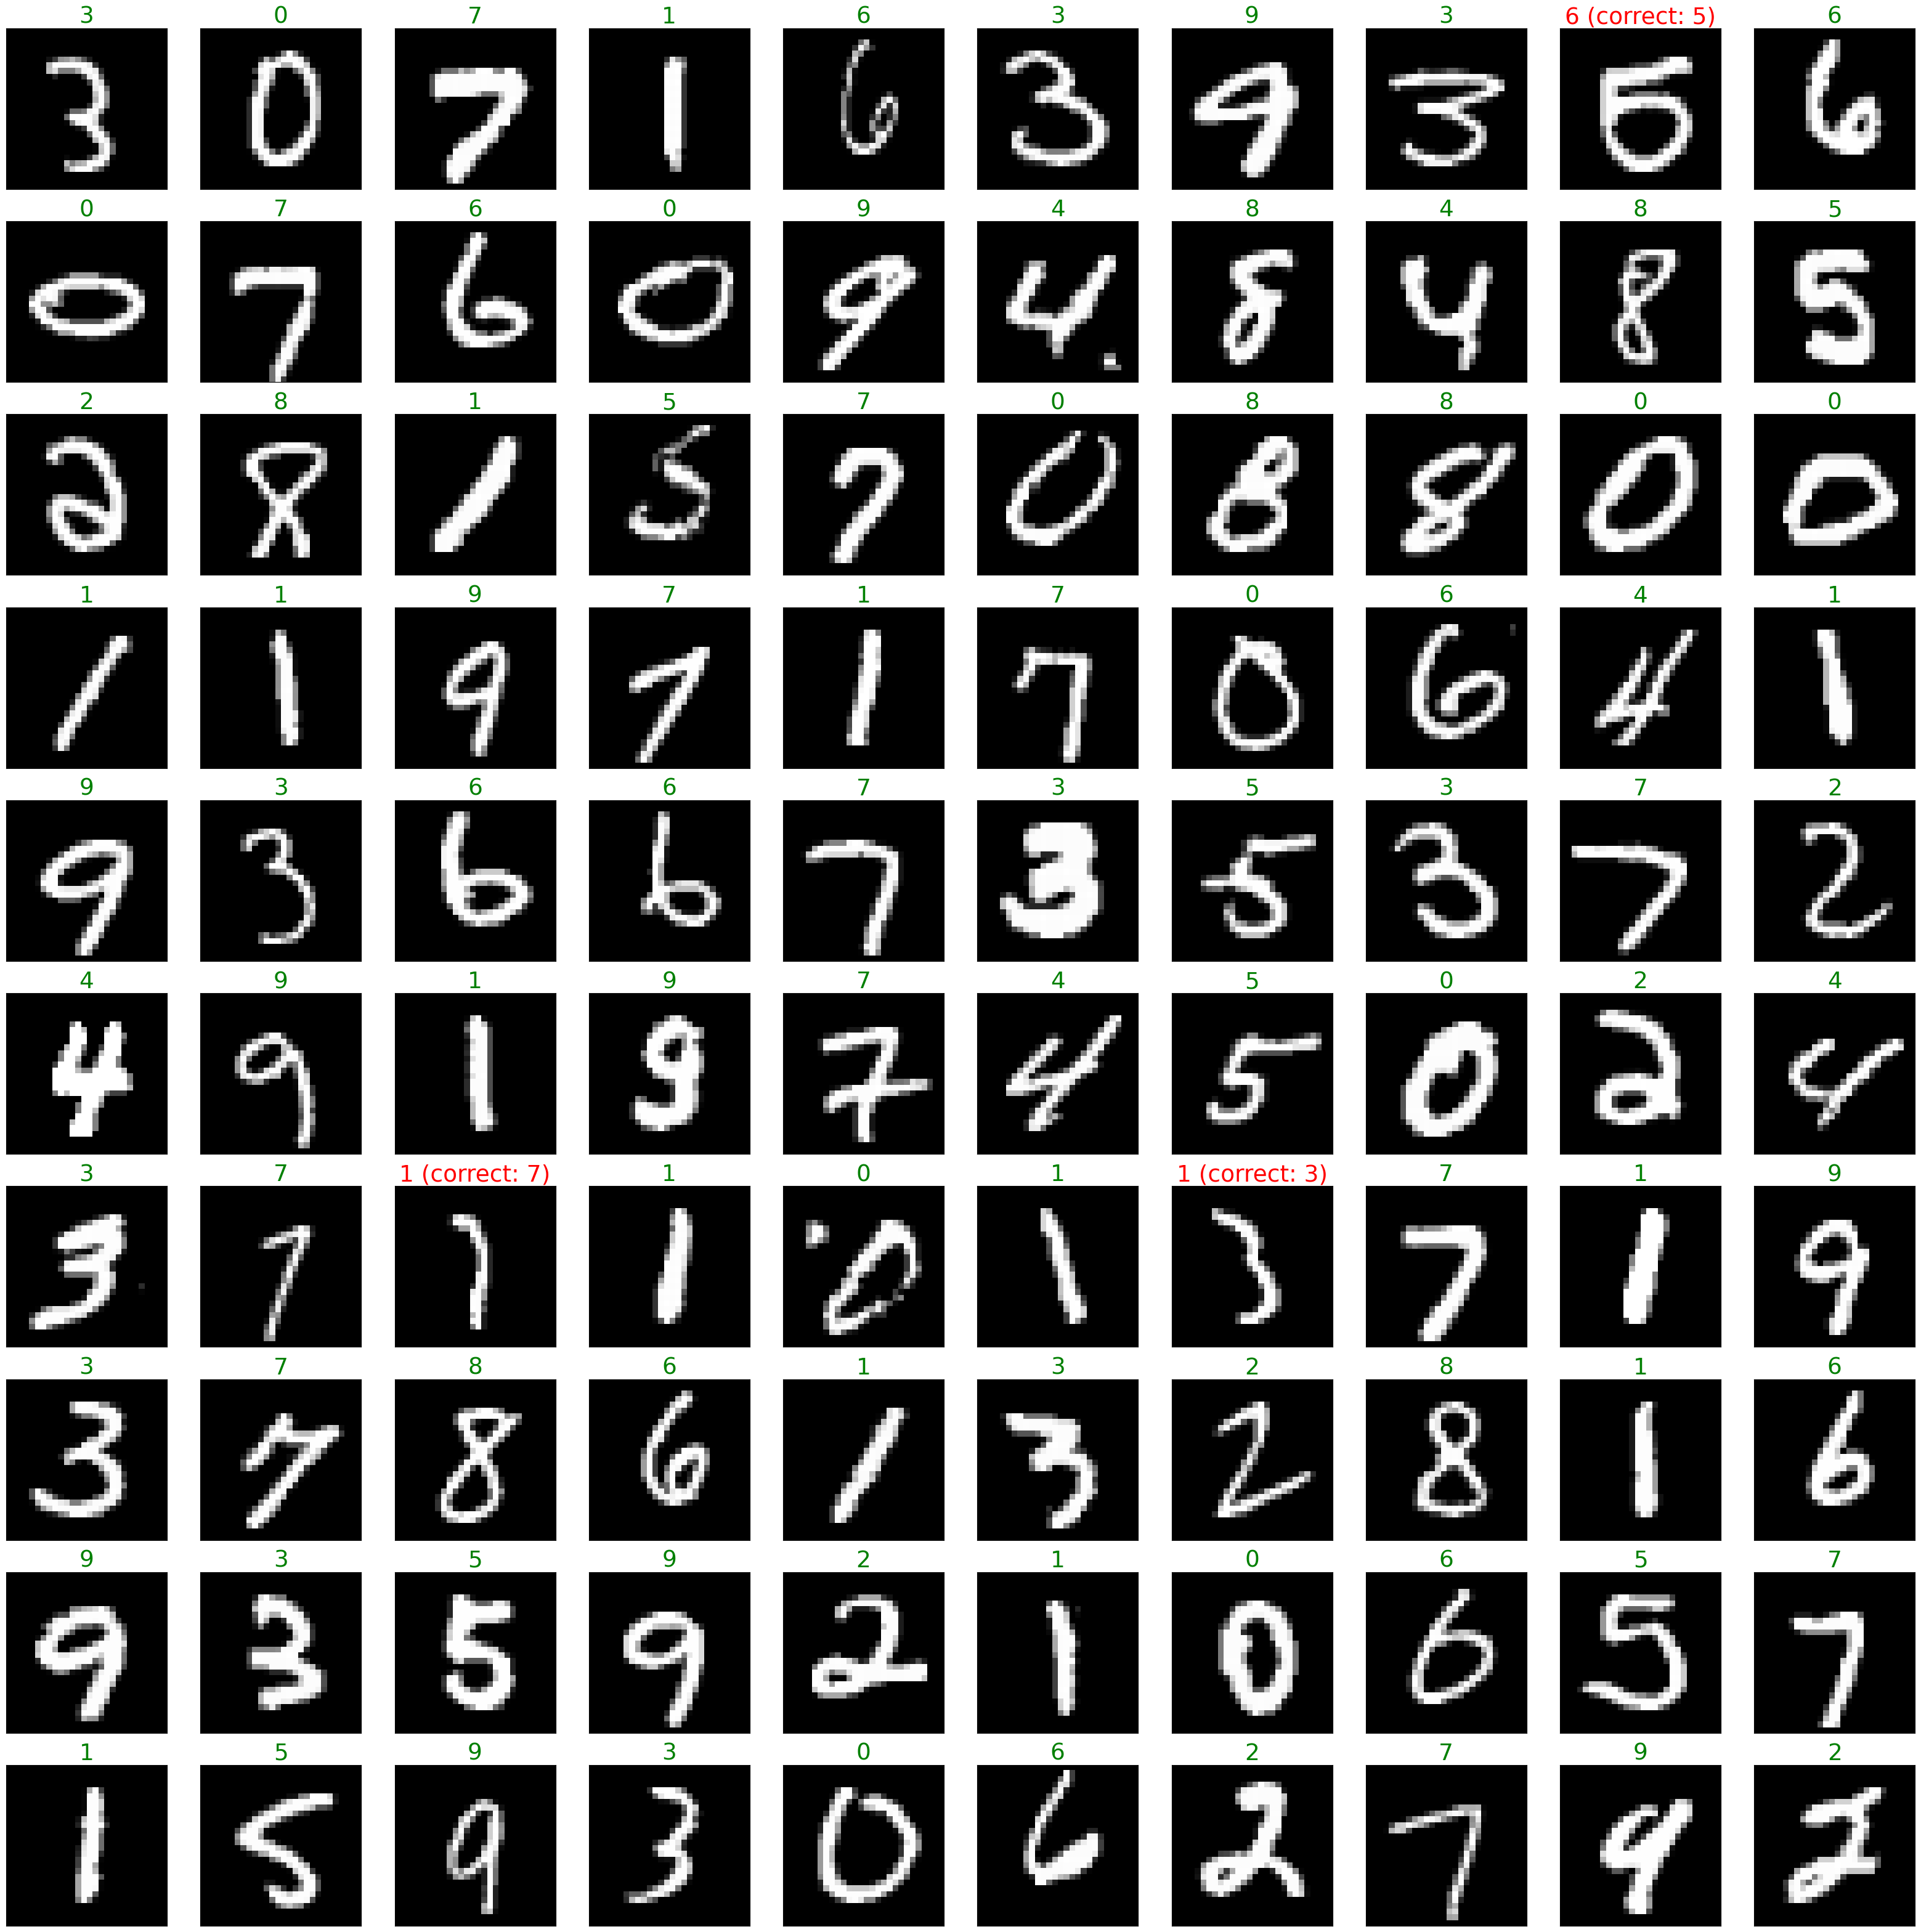


Accuracy: 98.53%


In [6]:
test(loader, batch_size)

In [7]:
def save_embeddings(cnn, dataloader, filename):
    embeddings_data = []

    cnn.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            embeddings = cnn(images)
            for i in range(len(images)):
                embedding = embeddings[i].numpy()
                img = images[i].numpy()
                label = labels[i].item()
                data_entry = {"image": img, "label": label, "embedding": embedding}
                embeddings_data.append(data_entry)

    with open(filename, "wb") as f:
        pickle.dump(embeddings_data, f)


def load_embeddings(filename):
    with open(filename, "rb") as f:
        embeddings_data = pickle.load(f)

    embeddings = [entry["embedding"] for entry in embeddings_data[:500]]
    labels = [entry["label"] for entry in embeddings_data[:500]]

    reducer = umap.UMAP()
    embeddings_2d = reducer.fit_transform(embeddings)

    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="tab10")
    plt.colorbar()
    plt.title("MNIST")
    plt.show()

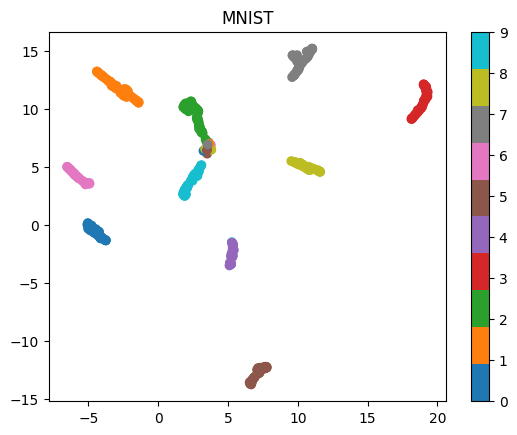

In [8]:
filename = "/content/drive/MyDrive/CNNs/Torch/embeddings.pickle"

save_embeddings(cnn, loader, filename)
load_embeddings(filename)